## Time domain <a class="anchor" id="section-2"></a>

Fitted parameters:
t0 = 3.2971778382304655 ns
E0 = 0.048692671508939744 eV
s = 1118.0164382464015 mm


,"Energy, eV","Theory, ns","t, ns","dt, ns","dt/t, %","dE/E, %","dE, eV","Sigma, ns"
0,14.40,500.744879,500.801742,0.680902,0.135962,0.271925,0.019579,0.034086
1,13.08,525.404624,525.467617,0.623233,0.118605,0.237211,0.015514,0.022700
2,11.27,566.025250,565.995547,0.784373,0.138583,0.277166,0.015618,0.039805
3,9.95,602.401747,602.273357,1.237909,0.205539,0.411079,0.020451,0.000014
4,8.16,665.200679,664.962628,1.178424,0.177217,0.354433,0.014461,0.000019
5,6.84,726.557035,726.665262,0.833638,0.114721,0.229442,0.007847,0.327594


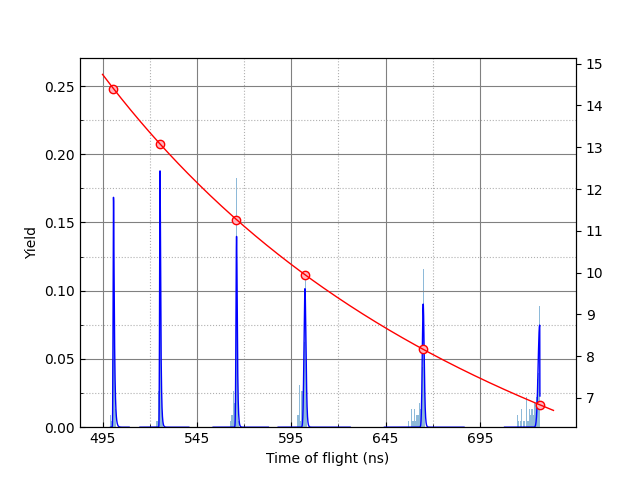

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from funcs import *

fig, ax = plt.subplots()

x_start=495
x_end = 700
x_interval = 50
y_start = 0
y_end = 0.25
y_interval = 0.05
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"Time of flight (ns)", r"Yield", set=False)

data = read_file('./data/6k_low.txt', delimeter=None)[0]
y, x, _ = plt.hist(data, 3000, alpha=0.5, density=True)
x = (x[1:] + x[:-1])/2

times, sigmas, widths = [], [], []
energies = [14.40, 13.08, 11.27, 9.95, 8.16, 6.84]
straight_times = time_of_flight(np.array(energies))

bins = [(0, 509.2), (514.9, 540.8), (553.7, 583), (588.1, 626.4), (644.4, 686.7), (708.1, 732.3)]
for i, lim in enumerate(bins):
    start, stop = get_bins(lim, x)
    peak_x, sig, width = approximate(x[start:stop], y[start:stop], ax,
                                    (straight_times[i], 1, 0, 1, 1))
    times.append(peak_x)
    sigmas.append(sig)
    widths.append(width)

times, sigmas, widths = np.array(times), np.array(sigmas), np.array(widths)

xr = np.arange(495, 735, 1)
params, _ = curve_fit(time_to_energy, times, energies, (0, 0, 1117))
print(f"Fitted parameters:\nt0 = {params[0]*1e9} ns\nE0 = {params[1]} eV\ns = {params[2]} mm")

ax2 = ax.twinx()
ax2.scatter(times, energies, facecolors='#FFB6C1', edgecolors='r')
ax2.plot(xr, time_to_energy(xr, *params), lw=1, c='red')

d = {
    "Energy, eV": energies[:len(times)],
    "Theory, ns": straight_times[:len(times)],
    "t, ns": times,
    "dt, ns": widths,
    "dt/t, %": widths/times*100,
    "dE/E, %": widths/times*200,
    "dE, eV": widths/times*energies,
    "Sigma, ns": sigmas,
}
df = pd.DataFrame(data=d)
df

## Bundle's deviation <a class="anchor" id="section-5"></a>

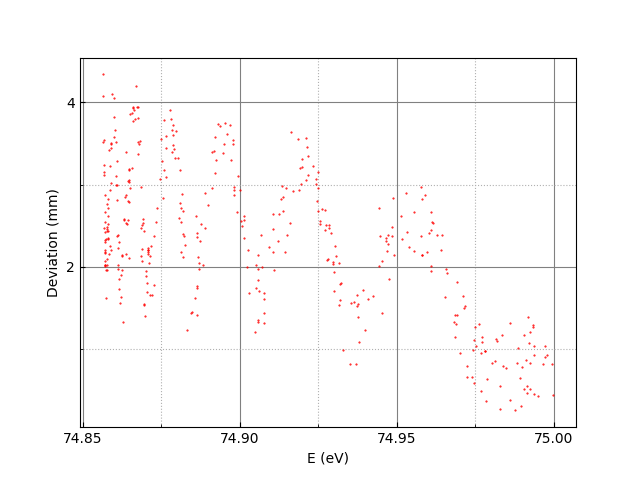

In [14]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from funcs import *

fig, ax = plt.subplots()
x_start = 74.85
x_end = 75
x_interval = 0.05
y_start = 0
y_end = 10
y_interval = 2
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"E (eV)", r"Deviation (mm)", set=False)

x = np.arange(x_start, x_end, 1)
energies = [14.40, 13.08, 11.27, 9.95, 8.16, 6.84]
e, r = [], []
with open("./data/dist_coords_ret_new.txt", "r") as f_c:
    with open("./data/dist_energies_ret_new.txt", "r") as f_e:
        while True:
            s_c = f_c.readline()
            s_e = f_e.readline()
            if s_c == "" or s_e == "":
                break
            num_c = s_c.split()
            num_e = s_e.split()
            if float(num_c[2]) == 516.0:
                r.append(np.sqrt(float(num_c[1]) ** 2 + float(num_c[3]) ** 2))
                e.append(float(num_e[1]))

ax.scatter(e, r, s=0.25, c="red", zorder=3)
# ax.vlines(energies, 0, 5, lw=1, color='b')

## 23.76eV single peak <a class="anchor" id="section-8"></a>

234.50205519588508


,"Energy, eV","Theory, ns","t, ns","dt, ns","dt/t, %","dE/E, %","dE, eV","Sigma, ns"
0,10,275.120878,234.696,4.217133,1.796849,3.593698,0.179685,3.296585


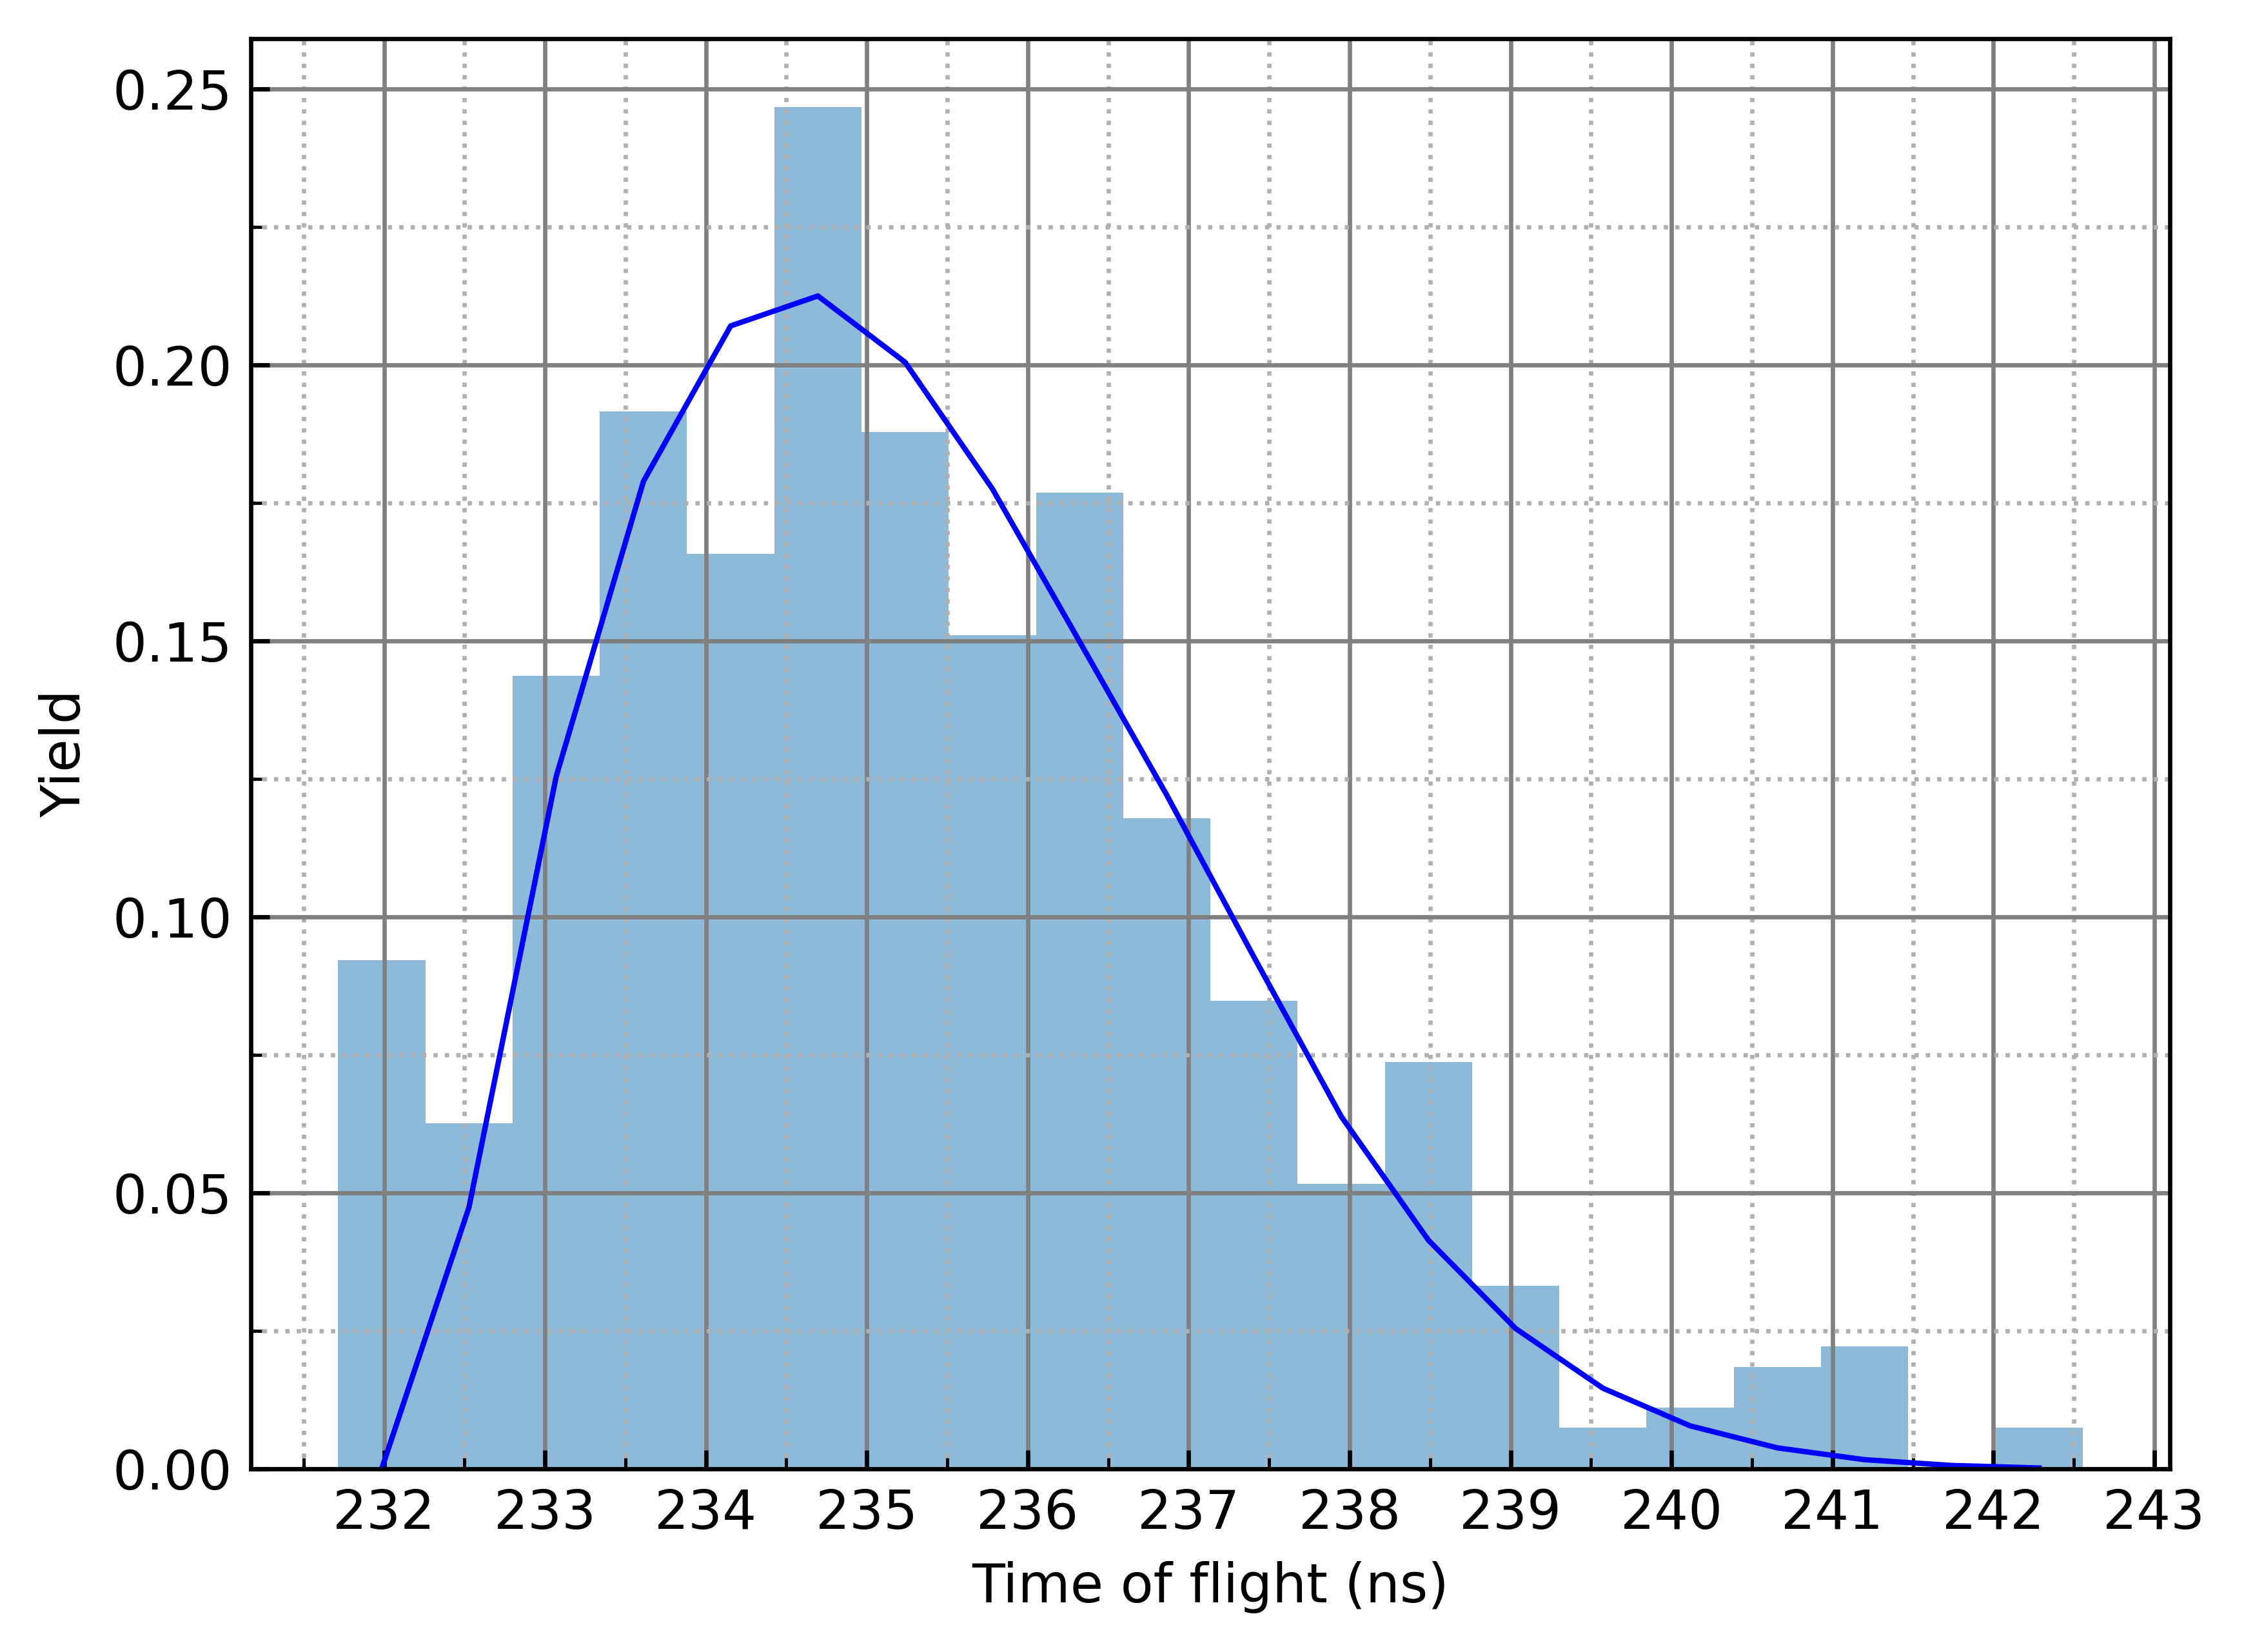

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import *
from scipy.optimize import curve_fit
from scipy.signal import peak_widths, find_peaks
from funcs import *

fig, ax = plt.subplots(dpi=600)
x_start = 231
x_end = 243
x_interval = 1
y_start = 0
y_end = 0.1
y_interval = 0.05
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
    r"Time of flight (ns)", r"Yield", set=False)

data, _ = read_file('./data/1k_ret_new.txt', delimeter=None)
y, x, _ = hist(data, 20, alpha=0.5, density=True)
x = (x[1:] + x[:-1]) / 2

times, sigmas, widths = [], [], []
energies = [75-65]
straight_times = time_of_flight(np.array(energies))

def energy_from_time(t, ret_pos, v_ret):
    return 6.242e18*ELECTRON_MASS*0.5*(TUBE_LENGTH*1e6/t)**2

def time_of_flight(E: float, L):  # ns
    return L / velocity(E) * 1e9

bins = [(230, 244)]
for i, lim in enumerate(bins):
    start, stop = get_bins(lim, x)
    peak_x, sig, width = approximate(x[start:stop], y[start:stop], ax, (234, 1, 1, 1, 1))
    times.append(peak_x)
    sigmas.append(sig)
    widths.append(width)

times, sigmas, widths = np.array(times), np.array(sigmas), np.array(widths)
print(time_of_flight(75, 120)+time_of_flight(10, 516-120))
d = {
    "Energy, eV": energies[:len(times)],
    "Theory, ns": straight_times[:len(times)],
    "t, ns": times,
    "dt, ns": widths,
    "dt/t, %": widths/times*100,
    "dE/E, %": widths/times*200,
    "dE, eV": widths/times*energies,
    "Sigma, ns": sigmas,
}
df = pd.DataFrame(data=d)
df